
About this tutorial

Audience

This tutorial has been prepared for those who want to understand HDF5 GOME Level2 data structure, conduct some basic operations on it and plot an image/map.
Prerequisites

    basic understanding of xarray library for data processing
    to visualize dataset you probably need basic knwoledge about:
    matplotlib for plotting
    cartopy for maps

What we will learn:

    navigate HDF5 file product using h5py
    manage xarray dataset/datarray
    xarray plotting capabilities

Background:

For this example we use a HDF5 GOME Level 2 product. The content of this kind of product comprises the following groups:

    META_DATA
        Product Metadata

    GEOLOCATION

        Date & Time (all retrievals)

        4 Corner Coordinates & Centre of Ground Pixel

        Solar, Line-of-Sight Zenith, and relative Azimuth angles at TOA

        Orbit information

    TOTAL_COLUMNS
        Total and tropospheric column amounts of the various trace gases with corresponding (relative) errors

    CLOUD_PROPERTIES
        Retrieved cloud properties

    DETAILED_RESULTS

        Geophysical parameters (surface, cloud and aerosol values)

        Vertical column, slant column, and AMF values with corresponding errors

        Fitting diagnostics (chi-square, RMS, etc.)

        Various subgroups for trace gas specific data (e.g. O 3 , NO 2 , SO 2 , etc.)

# Environment configuration

Libraries to manage HDF5 file and arrays:


In [1]:
import h5py

For plotting and mapping:

In [2]:
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
import xarray as xr

# Read data

In [3]:
filepath = 'DATA/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20190204122036_049_METOPB_33114_DLR_04.HDF5'

We read the file using functions from the h5py library. Note that to use a library in python you use the imported alias followed by a dot, and then the function you want (e.g. h5py.Dataset).

In [4]:
f = h5py.File(filepath, 'r')

The f file object is your starting point. h5py.File acts like a Python dictionary, thus we can check the keys:

In [5]:
groups = sorted(f.keys())
groups

[u'CLOUD_PROPERTIES',
 u'DETAILED_RESULTS',
 u'GEOLOCATION',
 u'META_DATA',
 u'TOTAL_COLUMNS']

In [6]:
for group in groups:
    print('{}:'.format(group))
    # variables in a group
    variables = sorted(f[group].keys())
    # pretty print of variables in 3 columns
    for v1, v2, v3 in zip(variables[::3], variables[1::3], variables[2::3]):
        print('   - {:<30}- {:<30}- {:<}'.format(v1, v2, v3))
    if (len(variables) % 3) == 1:
        print('   - {:<30}'.format(variables[-1]))
    elif (len(variables) % 3) == 2:
        print('   - {:<30}- {:<}'.format(*variables[-2:]))
    # white line between one line and another
    print()

CLOUD_PROPERTIES:
   - CloudFraction                 - CloudFraction_Error           - CloudMode
   - CloudOpticalThickness         - CloudOpticalThickness_Error   - CloudTopAlbedo
   - CloudTopAlbedo_Error          - CloudTopHeight                - CloudTopHeight_Error
   - CloudTopPressure              - CloudTopPressure_Error        - CloudType
   - PMDCloudFraction              
()
DETAILED_RESULTS:
   - AAI                           - AMFToCloudTop                 - AMFToCloudTop_Error
   - AMFToGround                   - AMFToGround_Error             - AMFTotal
   - AMFTotal_Error                - BrO                           - Clouds
   - ESC                           - ESC_Error                     - FittingChiSquare
   - FittingGoodness               - FittingNumberOfIterations     - FittingRMS
   - H2O                           - HCHO                          - IntensityWeightedCloudFraction
   - NO2                           - O3                            - QualityFlags
  

Suppose we are interested in the Total vertical column density of NO$_2$. We can get this variable using its internal path TOTAL_COLUMNS/NO$_2$. The object we obtained isn't an array, but an HDF5 dataset. Like NumPy arrays, datasets have both a shape and a data type:

In [47]:
no2 = f['TOTAL_COLUMNS/NO2Tropo']
no2

<HDF5 dataset "NO2Tropo": shape (14931,), type "<f4">

Attributes are accessed through the attrs proxy object, which again implements the dictionary interface:

In [37]:
dict(no2.attrs)

{u'CheckSum': array([-1939368446], dtype=int32),
 u'FillValue': array([-1.], dtype=float32),
 u'Title': array(['Vertical column density of O3'], dtype='|S29'),
 u'Unit': array(['Dobson Units'], dtype='|S12'),
 u'ValueRangeMax': array([536.0669], dtype=float32),
 u'ValueRangeMin': array([80.40985], dtype=float32)}

# Create an array for xarray

To easy handle the NO$_2$ dataset we create a xarray DataArray. We set longitude and latitude of the centre of the ground pixel as coordinates of the datarray.


In [50]:
latitude = f['GEOLOCATION/LatitudeCentre']
longitude = f['GEOLOCATION/LongitudeCentre']

no2_da = xr.DataArray(
    no2,
    dims=('ground_pixel'),
    coords={
        'latitude': ('ground_pixel', latitude[:]),
        'longitude': ('ground_pixel', longitude[:])
    },
    attrs={'long_name': 'Vertical column density of NO2', 'units': 'mol/cm2'}
)

no2_da

<xarray.DataArray u'/TOTAL_COLUMNS/NO2Tropo' (ground_pixel: 14931)>
array([-1.000000e+00, -1.000000e+00,  2.137072e+15, ..., -1.000000e+00,
       -1.000000e+00, -1.000000e+00], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 61.95914 62.386345 ... -75.49544 -75.15474
    longitude  (ground_pixel) float32 353.48596 352.25348 ... 135.00522
Dimensions without coordinates: ground_pixel
Attributes:
    units:      mol/cm2
    long_name:  Vertical column density of NO2

# Plotting the data

We generate a very simple scatter plot using the xarrays plotting capabilities:

We plot on a map the posititon of satellite single pixels:

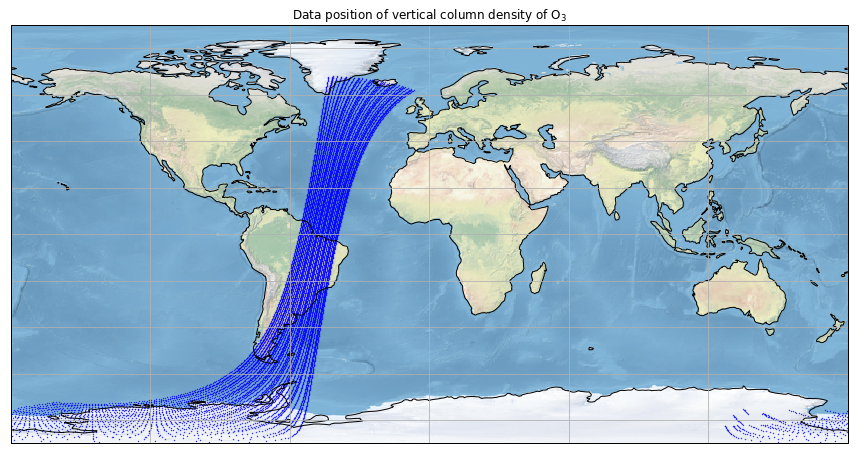

In [51]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# set map background and features
ax.stock_img()
ax.coastlines()

# set gridlines
ax.gridlines()

# plot O3 pixel positions
ax.scatter(
    no2_da.longitude.data,
    no2_da.latitude.data,
    c='b',
    marker='o',
    s=0.15,
    transform=ccrs.PlateCarree()
)
ax.set_title(r'Data position of vertical column density of O$_3$')
plt.show()

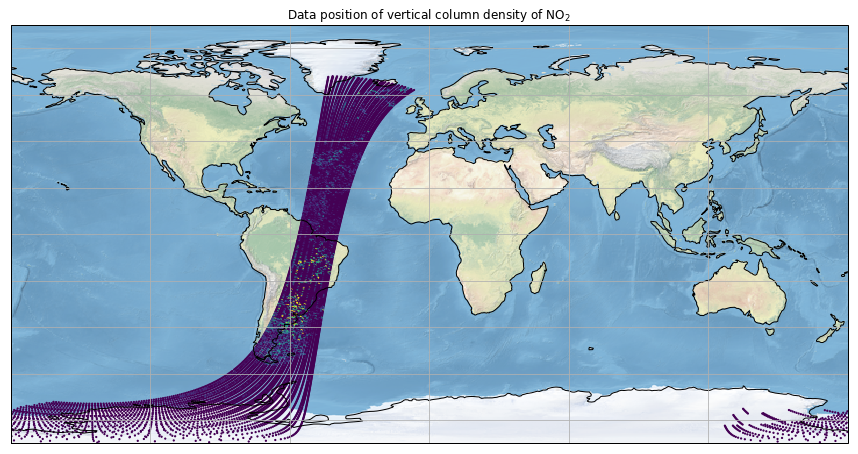

In [52]:
color=no2_da.data*1e-16
rng=(0,0.5)  # Put a range values for the color plot

fig, ax = plt.subplots(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# set map background and features
ax.stock_img()
ax.coastlines()

# set gridlines
ax.gridlines()

# plot NO2 pixel positions
ax.scatter(
    no2_da.longitude.data,
    no2_da.latitude.data,
    c=color,
    marker='o',
    s=1.5,
    norm=plt.Normalize(rng[0],rng[1]),
    transform=ccrs.PlateCarree()
)
ax.set_title(r'Data position of vertical column density of NO$_2$')
#ax.colorbar(label=no2_da.units)
plt.show()
#fig.savefig('myAC-SAFL2plot.png', bbox_inches='tight')

# References

h5py quick start guide: http://docs.h5py.org/en/stable/quick.html

xarray plotting: http://xarray.pydata.org/en/stable/plotting.html